In [1]:
import numpy as np 
import pandas as pd 
import sys 

from DataManager import DataManager 


def normalize_data(X):
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)
    X_n = (X - mu) / sigma
    return X_n, mu, sigma

def norm_eq(X, y):
    theta = np.dot(np.dot(np.linalg.pinv(np.dot(X.T, X)), X.T), y)
    return theta

def shuffle_index(X, y):
    m, n = X.shape
    sidx = np.random.permutation(m)
    return sidx, X[sidx], y[sidx]

def chunk_validation_set(portion, X, y):
    m, n = X.shape
    sidx, sX, sy = shuffle_index(X, y)
    nval = int(portion*m)
    trainX = X[nval:]
    trainy = y[nval:]
    valX = X[0:nval]
    valy = y[0:nval]
    return trainX, trainy, valX, valy

def remove_non_positive_data(X, y):
    Xmask = np.all(X > 0, axis=1)
    ymask = np.all(y > 0, axis=1)
    mask = Xmask & ymask
    return X[mask], y[mask]

def remove_strange_data(X, y):
    Xmask = np.all(X < 300, axis=1)
    ymask = np.all(y < 300, axis=1)
    mask = Xmask & ymask
    return X[mask], y[mask]

def preprocess_data(X, y):
    X, y = remove_non_positive_data(X, y)
    X, y = remove_strange_data(X, y)
    return X, y 


def predict(theta, instance):
    h_theta = np.dot(instance, theta)
    return h_theta

def h(X, theta):
    return np.dot(X, theta)

def J(theta, h, lamb, X, y):
    m, n = X.shape
    square_error = np.sum((h(X, theta) - y)**2)
    regularization = lamb * np.dot(theta[1:].T, theta[1:])
    return (1 / 2) * (1 / m) * (square_error + regularization)

def gradient_descent(theta, h, X, y, eta, lamb, n_iters):
    m, n = X.shape
    theta_record = np.zeros((n_iters, *theta.shape))
    loss_record = np.zeros((n_iters, 1))
    
    theta_record[0] = theta
    loss_record[0] = J(theta, h, lamb, X, y)
    grad_square_sum = np.zeros(theta.shape)
    for i in range(1, n_iters):
        total_grad = np.dot(X.T, (h(X, theta) - y))
        total_grad[1:] = total_grad[1:] + lamb * theta[1:]
        grad = (1 / m) * total_grad
        
        grad_square_sum = grad**2 + grad_square_sum
        
        theta = theta - eta * grad / np.sqrt(grad_square_sum)
        theta_record[i] = theta
        loss_record[i] = J(theta, h, lamb, X, y)
        
    return theta, theta_record, loss_record

def initialize_theta_randomly(X, y):
    m, n = X.shape
    return np.random.normal(loc=0, scale=1, size=(n, 1))

def initialize_theta_to_zero(X, y):
    m, n = X.shape
    return np.zeros((n, 1))

def initialize_theta(X, y):
    return norm_eq(X, y)

def find_example_error(theta, h, J, lamb, X, y):
    error_list = []

    for i, example in enumerate(zip(X, y)):
        xx, yy = example
        xx = xx.reshape((1, -1))
        yy = yy.reshape((1, 1))
        error_list.append((J(theta, h, lamb, xx, yy), i, xx, yy))

    return sorted(error_list, reverse=True)

def validate_data(rate, h, J, lamb, X, y):
    norm_theta = norm_eq(X, y)
    error_list = sorted(find_example_error(norm_theta, h, J, lamb, X, y), reverse=True)
    to_drop = error_list[0:int(rate*len(error_list))]
    to_drop_idx = [idx for err, idx, xx, yy in to_drop]
    return np.delete(X, to_drop_idx, axis=0), np.delete(y, to_drop_idx, axis=0)




# SELECTED_FEATURE = ['PM2.5']
SELECTED_FEATURE = None
CHUNK_SIZE = 4
# VALIDATE_RATE = 0.15
ETA = 0.1
ETA_LIST = [0.001, 0.01, 0.1, 1.0]
LAMBDA = 0.001
LAMBDA_LIST = [0.01, 0, 1, 100, 10000, 1000000, 100000000]
N_ITERS = 200


In [2]:
import matplotlib.pyplot as plt

In [3]:
input_file = './train.csv'


dm = DataManager()

dm.read_training_data(input_file)

mdfs = dm.select_feature_to_mdfs(SELECTED_FEATURE)

X, y = dm.chunk_examples(mdfs, chunk_size=CHUNK_SIZE)

X, y = preprocess_data(X, y)

X_n, mu, sigma = normalize_data(X)

X_n = np.insert(X_n, obj=0, values=1, axis=1)

In [4]:
trainX, trainy, valX, valy = chunk_validation_set(0.1, X_n, y)

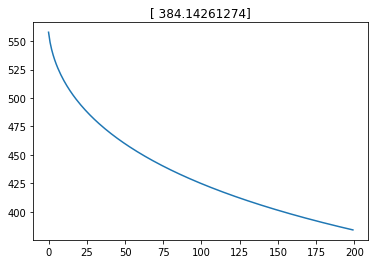

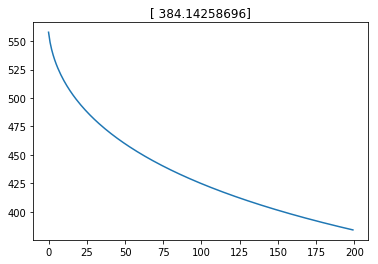

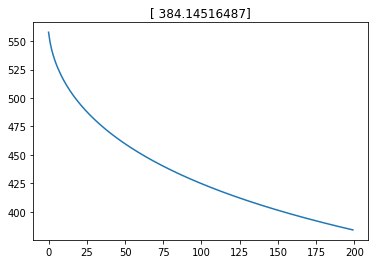

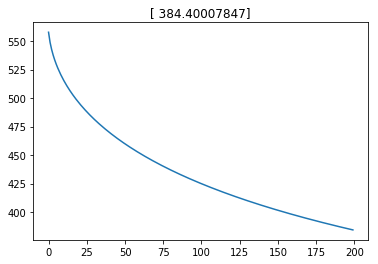

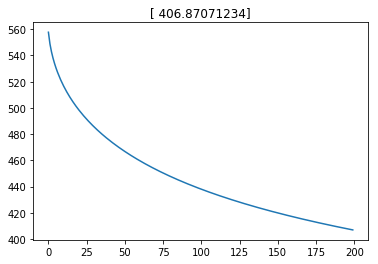

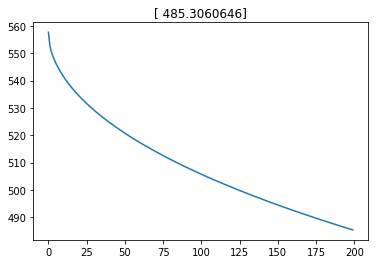

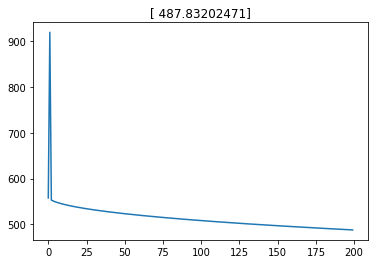

In [5]:
init_theta = initialize_theta_to_zero(X_n, y)
eta = ETA
lamb = LAMBDA
for lamb in LAMBDA_LIST:
    theta, theta_record, loss_record = gradient_descent(init_theta, h, X_n, y, eta=eta, lamb=lamb, n_iters=N_ITERS)
    fig, ax = plt.subplots()
    ax.set_title(str(loss_record[-1]))
    ax.plot(np.arange(loss_record.size), loss_record)
    

In [6]:
np.load('./model.npy')

array([[ 27.73235859],
       [  6.56217079],
       [ -9.61220032],
       [  0.26663376],
       [ 20.35172112]])